# Estimate synodic period

## Periods from literature

In [1]:
import requests
import io
import pandas as pd

bft_source = "local" # choose `net` to download it

cols = [
    'sso_number', 'sso_name', 'sso_class',
    'spins.1.period.value', 'spins.2.period.value',
]

if bft_source == "local":
    # Local Configuration
    bft_file = '/tmp/ssoBFT-latest.parquet' 
    bft = pd.read_parquet(bft_file, columns=cols)
elif bft_source == 'net':
    r = requests.get("https://ssp.imcce.fr/data/ssoBFT-latest_Asteroid.parquet")
    bft = pd.read_parquet(io.BytesIO(r.content), columns=cols)
    bft.to_parquet("/tmp/ssoBFT-latest.parquet")

## Estimate periods from number

In [12]:
ssnamenr = 186153 # high cadence
ssnamenr = 5209 # nice fit

In [2]:
from fink_utils.sso.periods import extract_period_from_number
import time

for flavor in ["SHG1G2", "HG", "HG12", "HG1G2"]:
    t0 = time.time()
    period, chi2red = extract_period_from_number(ssnamenr, flavor, Nterms_base=2, period_range=(0.05, 1.2))
    print(
        "[{:.2f} seconds] model={}: period={:.2f} hours (chi2red={:.2f}) -- BFT: period={:.2f} hours".format(
            time.time() - t0,
            flavor,
            period,
            chi2red,
            bft[bft["sso_number"] == ssnamenr]["spins.1.period.value"].values[0]
        )
    )

[38.62 seconds] model=SHG1G2: period=5.80 hours (chi2red=0.67) -- BFT: period=11.60 hours
[37.70 seconds] model=HG: period=5.80 hours (chi2red=1.17) -- BFT: period=11.60 hours
[39.89 seconds] model=HG12: period=5.80 hours (chi2red=1.12) -- BFT: period=11.60 hours
[36.01 seconds] model=HG1G2: period=5.80 hours (chi2red=1.08) -- BFT: period=11.60 hours


In [27]:
bft[bft["sso_number"] == ssnamenr]["spins.1.period.value"].values[0]

11.6027

- All models give the same period estimates
- The HG1G2 model gives the best reduced chi2. sHG1G2 might be overfitting here as it is roundish (R~0.86).
- The estimated period is 1/2 the period found in the literature (5.8 vs 11.6 hours)

## Detailed fit

In [3]:
from fink_utils.sso.periods import extract_period_from_number

flavor = "SHG1G2"
period, chi2red, model, pdf = extract_period_from_number(
    ssnamenr, flavor, Nterms_base=2, period_range=(0.05, 1.2), return_extra_info=True
)

### Residuals

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")

import numpy as np

Text(0, 0.5, 'Residual (mag)')

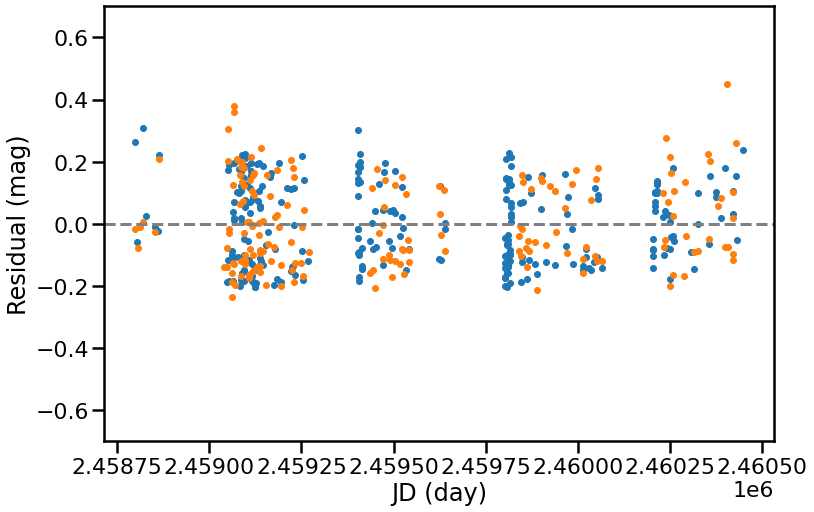

In [5]:
fig = plt.figure(figsize=(12, 8))

for filtnum in pdf["i:fid"].unique():
    cond = pdf['i:fid'] == filtnum
    plt.plot(pdf['i:jd'][cond], pdf["residuals"][cond], ls="", marker='.')
plt.axhline(0, ls="--", color="grey")
plt.ylim(-0.7, 0.7)
plt.xlabel("JD (day)")
plt.ylabel("Residual (mag)")

### Period

Text(0, 0.5, 'Residual (mag)')

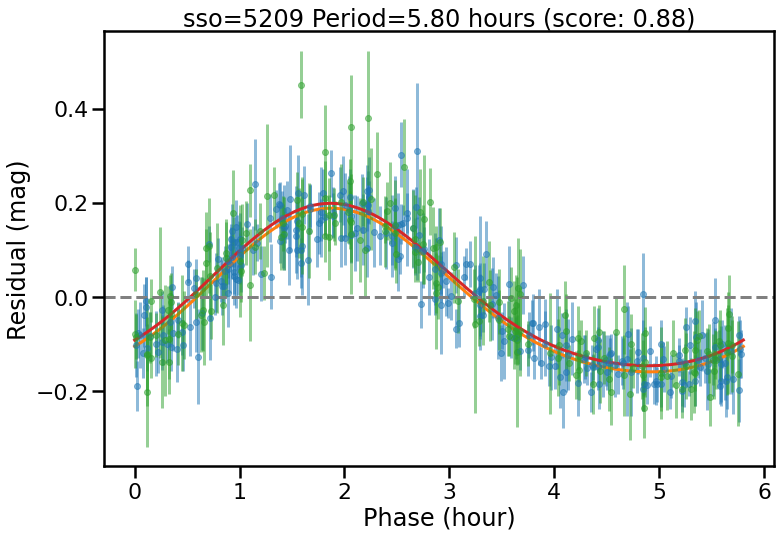

In [6]:
fig = plt.figure(figsize=(12, 8))

best_period_2 = model.best_period * 1
for filtnum in pdf["i:fid"].unique():
    cond = pdf['i:fid'] == filtnum    
    phase = pdf["i:jd"][cond] % best_period_2
    tfit = np.linspace(0, best_period_2, 100)
    magfit = model.predict(tfit, period=model.best_period, filts=filtnum)
    plt.errorbar(phase * 24, pdf["residuals"][cond], pdf['i:sigmapsf'][cond], ls="", marker='.', alpha=0.5)
    plt.plot(tfit * 24, magfit, ls="-", marker='')
plt.axhline(0, ls="--", color="grey")
# plt.ylim(-0.7, 0.7)
plt.title("sso={} Period={:.2f} hours (score: {:.2f})".format(ssnamenr, model.best_period * 24, model.score(model.best_period)))
plt.xlabel("Phase (hour)")
plt.ylabel("Residual (mag)")

### Periodogram

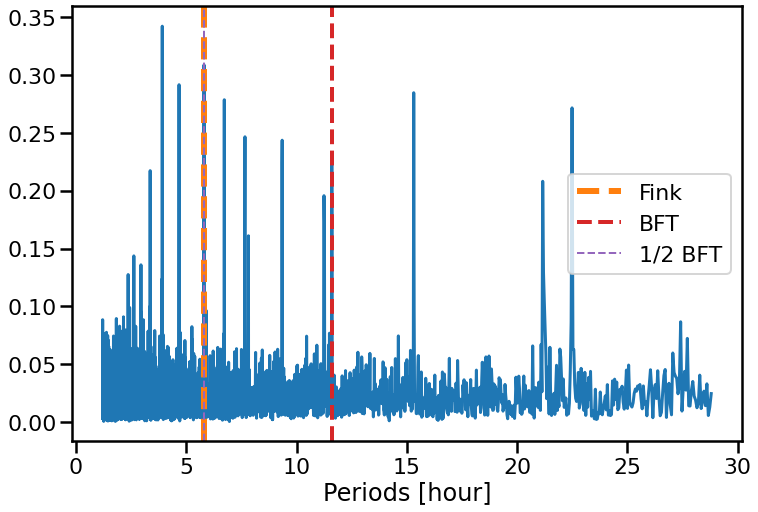

In [17]:
period_min = 0.05
period_max = 1.2
periods = 1 / np.linspace(1 / period_max, 1 / period_min, 10000)
powers = model.periodogram(periods)
fig = plt.figure(figsize=(12, 8))
plt.plot(periods * 24, powers)
plt.axvline(model.best_period * 24, ls='--', lw=6, color='C1', label="Fink")
plt.axvline(bft[bft["sso_number"] == ssnamenr]["spins.1.period.value"].values[0], ls='--', lw=4, color='C3', label="BFT")
plt.axvline(bft[bft["sso_number"] == ssnamenr]["spins.1.period.value"].values[0]/2, ls='--', lw=2, color='C4', label="1/2 BFT")

plt.xlabel("Periods [hour]")
plt.legend()

## The impact of sHG1G2

let's take objects with oblateness and a lot of observations


In [28]:
import io
import requests
import pandas as pd

r = requests.post(
  "https://fink-portal.org/api/v1/ssoft",
  json={
    "output-format": "parquet"
  }
)

# Format output in a DataFrame
ssoft = pd.read_parquet(io.BytesIO(r.content))

In [33]:
# Keep oblate ones
c0 = ssoft["R"] > 0.5
c1 = ssoft["R"] < 0.7
ssoft_oblate = ssoft[c0 & c1]

# Keep only known periods
data = ssoft_oblate.merge(bft, left_on="sso_name", right_on="sso_name", how="left")
data = data[data["spins.1.period.value"] == data["spins.1.period.value"]]

# sort by number of observations
data = data.sort_values("n_obs", ascending=False)

data[["sso_number_x", "sso_name_x", "R", "n_obs", "n_obs_1", "n_obs_2", "sso_class", "spins.1.period.value", "spins.2.period.value"]]

,ssnamenr,chi2red,min_cos_lambda,mean_cos_lambda,max_cos_lambda,status,fit,rms,rms_1,rms_2,...,sso_number_x,obliquity,alpha0_alt,delta0_alt,version,flag,sso_number_y,sso_class,spins.1.period.value,spins.2.period.value
5736,20729,2.200881,2.550984e-01,0.710034,0.985708,2.0,0.0,0.083050,0.080930,0.084361,...,20729.0,NaN,75.603333,52.852798,2024.08,0,20729.0,Trojan>L4,5.72000,7.6310
7273,22149,2.098735,1.251646e-01,0.555051,0.839964,2.0,0.0,0.079176,0.078367,0.079685,...,22149.0,NaN,323.514496,45.858692,2024.08,0,22149.0,Trojan>L4,6.75170,NaN
4887,1437,19.033417,6.807043e-02,0.491548,0.984572,2.0,0.0,0.131756,0.123765,0.136257,...,1437.0,76.287388,338.148727,-18.029423,2024.08,0,1437.0,Trojan>L4,24.49800,24.5010
7993,911,6.128680,1.753195e-02,0.561604,0.977883,2.0,0.0,0.069810,0.066154,0.072052,...,911.0,76.999382,323.935333,-39.069599,2024.08,0,911.0,Trojan>L4,6.58178,6.5818
21486,2363,3.089600,1.532393e-01,0.757258,0.987528,2.0,0.0,0.064795,0.065060,0.064594,...,2363.0,106.036386,281.008301,24.335510,2024.08,0,2363.0,Trojan>L5,20.07640,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20305,36171,5.619178,1.096416e-07,0.277183,0.853411,2.0,0.0,0.178659,0.183687,0.174262,...,36171.0,NaN,12.778381,6.772732,2024.08,0,36171.0,MB>Outer,79.98000,79.9800
5679,147366,2.465898,2.569049e-08,0.270052,0.482673,2.0,0.0,0.166511,0.164851,0.167521,...,147366.0,NaN,180.831204,-81.538483,2024.08,0,147366.0,MB>Middle,6.52018,58.5957
11527,322777,2.139305,6.404386e-09,0.282664,0.819525,3.0,0.0,0.153849,0.139199,0.162885,...,322777.0,NaN,46.990051,38.980129,2024.08,0,322777.0,MB>Outer,46.89300,NaN
27512,118239,2.859325,6.020184e-07,0.337770,0.696047,2.0,0.0,0.175237,0.178275,0.173651,...,118239.0,NaN,293.121346,19.906511,2024.08,0,118239.0,MB>Outer,4.64200,NaN


In [34]:
from fink_utils.sso.periods import extract_period_from_number

# ssnamenr_2 = 2363
ssnamenr_2 = 20729

period_shg1g2, chi2red_shg1g2, model_shg1g2, pdf_shg1g2 = extract_period_from_number(
    ssnamenr_2, flavor="SHG1G2", Nterms_base=2, period_range=(0.05, 1.2), return_extra_info=True
)

period_hg, chi2red_hg, model_hg, pdf_hg = extract_period_from_number(
    ssnamenr_2, flavor="HG", Nterms_base=2, period_range=(0.05, 1.2), return_extra_info=True
)

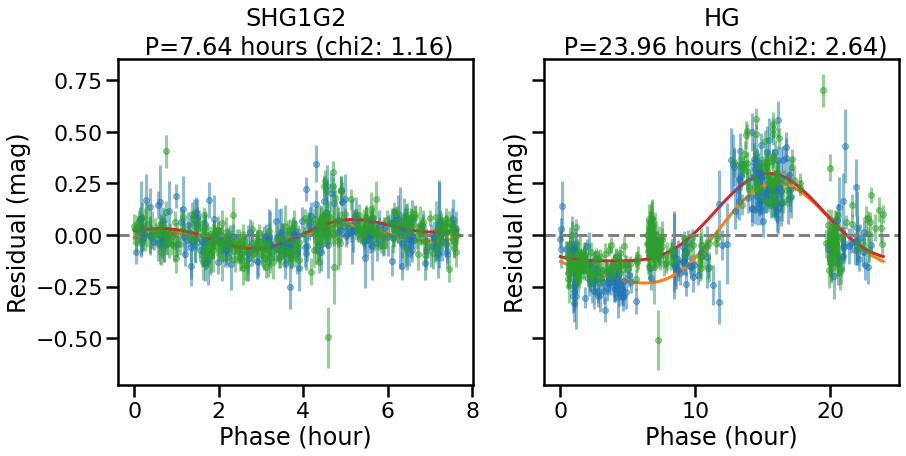

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

flavors = ["SHG1G2", "HG"]
for flavor, model_, pdf_, chi2red_ in zip(flavors, [model_shg1g2, model_hg], [pdf_shg1g2, pdf_hg], [chi2red_shg1g2, chi2red_hg]):
    for filtnum in pdf_["i:fid"].unique():
        cond = pdf_['i:fid'] == filtnum    
        phase = pdf_["i:jd"][cond] % model_.best_period
        tfit = np.linspace(0, model_.best_period, 100)
        magfit = model_.predict(tfit, period=model_.best_period, filts=filtnum)
        ax[flavors.index(flavor)].errorbar(phase * 24, pdf_["residuals"][cond], pdf_['i:sigmapsf'][cond], ls="", marker='.', alpha=0.5)
        ax[flavors.index(flavor)].plot(tfit * 24, magfit, ls="-", marker='')
    ax[flavors.index(flavor)].axhline(0, ls="--", color="grey")
    # plt.ylim(-0.7, 0.7)
    ax[flavors.index(flavor)].set_title("{}\n P={:.2f} hours (chi2: {:.2f})".format(
        flavor, model_.best_period * 24, chi2red_))
    ax[flavors.index(flavor)].set_xlabel("Phase (hour)")
    ax[flavors.index(flavor)].set_ylabel("Residual (mag)")

In [37]:
p1 = bft[bft["sso_number"] == ssnamenr_2]["spins.1.period.value"].values[0] # in hours
p2 = bft[bft["sso_number"] == ssnamenr_2]["spins.2.period.value"].values[0] # in hours
print(p1, p2)

5.72 7.631
